In [1]:
import jax
import jax.numpy as jnp
import numpy as np
from typing import NamedTuple


class RCMDP(NamedTuple):
    S_set: jnp.array  # state space
    A_set: jnp.array  # action space
    discount: float  # discount
    costs: jnp.array  # cost functions
    threshes: jnp.array  # constraint thresholds
    U: jnp.array  # uncertainty set
    init_dist: jnp.array  # initial distribution

    @property
    def S(self) -> int:  # state space size
        return len(self.S_set)

    @property
    def A(self) -> int:  # action space size
        return len(self.A_set)


S, A = 4, 2  # state and action space sizes
N = 1  # number of constraints
USIZE = 2  # size of uncertainty set
DISCOUNT = 0.40

assert USIZE == 2
assert N == 1

In [2]:
from typing import NamedTuple, Optional


def create_rcmdp():
    # create the RCMDP in Figure 1

    S_set = jnp.arange(S)
    A_set = jnp.arange(A)
    const = jnp.zeros(N)  # dummy

    # randomly create cost function
    costs = np.ones((N+1, S, A))

    eps = 0.09  # DISCOUNT / 4.5
    # objective 
    costs[0, 0, 0] = 0 + eps
    costs[0, 0, 1] = 1
    costs[0, 1, 0] = 1
    costs[0, 1, 1] = 1
    costs[0, 2, :] = 1
    costs[0, 3, :] = 0

    # constraint
    costs[1, 0, 0] = 1
    costs[1, 0, 1] = DISCOUNT - eps
    costs[1, 1, 0] = 1
    costs[1, 1, 1] = 1 - eps
    costs[1, 2, :] = 0
    costs[1, 3, :] = 1
    costs = jnp.array(costs)

    # create initial distribution
    init_dist = jnp.ones(S) / S
    # np.testing.assert_allclose(init_dist.sum(axis=-1), 1, atol=1e-6)

    # create uncertainty set
    U = np.zeros((USIZE, S, A, S))
    U[0, 0, 0, 1] = 1
    U[0, 0, 1, 0] = 1
    U[0, 1, 0, 0] = 1
    U[0, 1, 1, 1] = 1
    U[0, 2, :, 2] = 1
    U[0, 3, :, 2] = 1
    U[1, 0, 0, 1] = 1
    U[1, 0, 1, 0] = 1
    U[1, 1, :, 1] = 1
    U[1, 2, :, 3] = 1
    U[1, 3, :, 3] = 1
    U = jnp.array(U)

    const = 0.6 / (1 - DISCOUNT)
    rcmdp = RCMDP(S_set, A_set, DISCOUNT, costs, const, U, init_dist)
    return rcmdp

rcmdp = create_rcmdp()

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [3]:
import jax
import jax.numpy as jnp
import numpy as np
from functools import partial
import chex


@jax.jit
def compute_policy_matrix(policy: jnp.ndarray):
    """
    Args:
        policy (jnp.ndarray): (SxA) array

    Returns:
        policy_matrix (jnp.ndarray): (SxSA) array
    """
    S, A = policy.shape
    PI = policy.reshape(1, S, A)
    PI = jnp.tile(PI, (S, 1, 1))
    eyes = jnp.eye(S).reshape(S, S, 1)
    PI = (eyes * PI).reshape(S, S*A)
    return PI


@partial(jax.vmap, in_axes=(None, None, 0, None), out_axes=0)
@partial(jax.vmap, in_axes=(None, None, None, 0), out_axes=0)
def compute_policy_Q(discount: float, policy: jnp.ndarray, cost: jnp.ndarray, P: jnp.ndarray):
    """ Do policy evaluation with cost and transition kernel
    Args:
        discount (float): discount factor
        policy (jnp.ndarray): (SxA) array
        cost (jnp.ndarray): cost function. (SxA) array
        P (jnp.ndarray): transition kernel. (SxAxS) array

    Returns:
        Q (jnp.ndarray): (SxA) array
    """
    S, A = policy.shape

    Pi = compute_policy_matrix(policy)
    PPi = P.reshape(S*A, S) @ Pi
    Q = jnp.linalg.inv(jnp.eye(S*A) - discount * PPi) @ cost.reshape(S*A)
    return Q.reshape(S, A)


@partial(jax.vmap, in_axes=(None, None, None, 0), out_axes=0)
def compute_policy_visit_s(discount: float, policy: jnp.ndarray, init_dist: jnp.ndarray, P: jnp.ndarray):
    """ Compute (unnormalized) occupancy measure of a policy
    Args:
        discount (float): discount factor
        policy (jnp.ndarray): (SxA) array
        init_dist: initial distribution
        P (jnp.ndarray): (SxAxS) array

    Returns:
        d_pi (jnp.ndarray): (S) array
    """
    Pi = compute_policy_matrix(policy)
    PiP = Pi @ P.reshape(S*A, S) 
    d_pi = init_dist @ jnp.linalg.inv(jnp.eye(S) - discount * PiP)
    return d_pi


In [4]:
from functools import partial
from tqdm import tqdm


@partial(jax.vmap, in_axes=(None, 0))
def compute_Lone(rcmdp: RCMDP, policy: jnp.ndarray):
    """compute L1(pi) and ∇Lλ(pi)

    Args:
        rcmdp (RCMDP)
        policy (jnp.ndarray): policy

    Returns:
        L1(pi), ∇Lλ(pi)
    """
    Qs = compute_policy_Q(rcmdp.discount, policy, rcmdp.costs, rcmdp.U)  # N+1 x |U| x S x A
    Js = jnp.sum((Qs * policy.reshape(1, 1, S, A)).sum(axis=-1) * rcmdp.init_dist.reshape(1, 1, S), axis=-1)
    idx = jnp.argmax(Js, axis=-1)  # worst env index
    ds = compute_policy_visit_s(rcmdp.discount, policy, rcmdp.init_dist, rcmdp.U)
    chex.assert_shape(idx, (N+1, ))
    Js_U = jnp.zeros((N+1, ))
    for n in range(N+1):
        Js_U = Js_U.at[n].set(Js[n, idx[n]])

    Qs_U = jnp.zeros((N+1, S, A))
    for n in range(N+1):
        Qs_U = Qs_U.at[n].set(Qs[n, idx[n]])
    dsU = ds[idx]

    Lone = Js_U[0] + Js_U[1]

    Lgrad = dsU[0].reshape(S, 1) * Qs_U[0].reshape(S, A) \
        + dsU[1].reshape(S, 1) * Qs_U[1].reshape(S, A)
    return Lone, Lgrad


/tmp/ipykernel_125443/2554416251.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels)
/tmp/ipykernel_125443/2554416251.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ylabels)


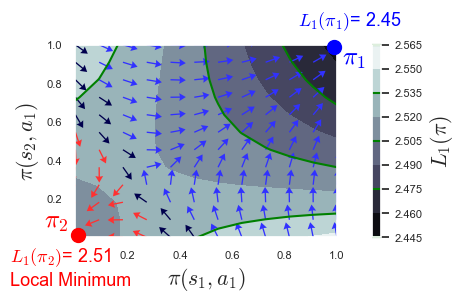

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
colormap = cm.seismic


plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = 'cm'
sns.set_theme(font_scale=1.3)
fig = plt.figure(figsize=(4.5, 2.5))
ax = plt.axes()
ax.set_xlabel(r"$\pi(s_1, a_1)$")
ax.set_ylabel(r"$\pi(s_2, a_1)$")

resol = 12

def compute_L_for_plot_area(x1, x2, y1, y2):
    pi11 = np.linspace(x1, x2, resol)
    pi21 = np.linspace(y1, y2, resol)
    Ls = []
    U = []
    V = []
    X, Y = np.meshgrid(pi11, pi21)
    policies = np.ones((resol, S, A)) / A  # to set values for state 3 and 4

    for pi11, pi21 in zip(X, Y):
        # state 1
        policies[:, 0, 0] = pi11
        policies[:, 0, 1] = 1 - pi11

        # state 2
        policies[:, 1, 0] = pi21 
        policies[:, 1, 1] = 1 - pi21
        Llam, Lgrad = compute_Lone(rcmdp, policies)
        Ls.append(Llam)
        grad_direction_s1 = Lgrad[:, 0, 1] - Lgrad[:, 0, 0]
        grad_direction_s2 = Lgrad[:, 1, 1] - Lgrad[:, 1, 0]
        U.append(grad_direction_s1)
        V.append(grad_direction_s2)

    Z, U, V = np.array(Ls), np.array(U), np.array(V)
    norm = np.linalg.norm(np.array((U, V)), axis=0)
    U = U / norm * 0.020
    V = V / norm * 0.020
    return X, Y, Z, U, V


X, Y, Z, U, V = compute_L_for_plot_area(0., 1, 0., 1)
# X, Y, Z, U, V = compute_L_for_plot_area(0, 0.45, 0, 0.45)
CS1 = ax.contourf(X, Y, Z, cmap=plt.cm.bone)
CS2 = ax.contour(CS1, levels=CS1.levels[::2], colors='green')

cbar = fig.colorbar(CS1, pad=0.1)
cbar.ax.set_ylabel(r"$L_1(\pi)$")
cbar.add_lines(CS2)
cbar.ax.tick_params(labelsize=8)

X, Y, U, V = X.reshape(-1), Y.reshape(-1), U.reshape(-1), V.reshape(-1)
qcolors = np.where((U > -0.01) * (V > -0.01), 0.3, 0)
qcolors = np.where((U <= 0.01) * (V <= 0.01), 0.7, qcolors)
ax.quiver(X, Y, U, V, color=colormap(qcolors), units='xy', scale=0.3, headwidth=6)
ax.tick_params(axis='both', which='major', labelsize=8)
xlabels = [item.get_text() for item in ax.get_xticklabels()]
xlabels[0] = ""
ylabels = [item.get_text() for item in ax.get_yticklabels()]
ylabels[0] = ""
ax.set_xticklabels(xlabels)
ax.set_yticklabels(ylabels)

plt.scatter(0.01, 0.01, s=100, color="red", clip_on=False, zorder=10)
plt.text(-0.12, 0.05, r"$\pi_2$", fontsize=18, color="red")
plt.text(-0.25, -0.13, r"$L_1(\pi_2)$=" f"{Z[0][0]: .2f}", fontsize=13, color="red")
plt.text(-0.25, -0.25, "Local Minimum", fontsize=13, color="red")

plt.scatter(0.99, 0.99, s=100, color="blue", clip_on=False, zorder=10)
plt.text(0.85, 1.1, r"$L_1(\pi_1)$=" f"{Z[-1][-1]: .2f}", fontsize=13, color="blue")
plt.text(1.02, 0.9, r"$\pi_1$", fontsize=18, color="blue")
# plt.title(r"Policy Gradient near $\pi_2$", y=1.04)

plt.savefig(f"results/conflict.pdf", bbox_inches="tight")
plt.savefig(f"results/conflict.png", bbox_inches="tight")